In [1]:
import os
import tensorflow as tf
# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("chest_xray"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'chest_xray'.
There are 2 directories and 0 images in 'chest_xray\test'.
There are 0 directories and 234 images in 'chest_xray\test\NORMAL'.
There are 0 directories and 390 images in 'chest_xray\test\PNEUMONIA'.
There are 2 directories and 0 images in 'chest_xray\train'.
There are 0 directories and 1341 images in 'chest_xray\train\NORMAL'.
There are 0 directories and 3875 images in 'chest_xray\train\PNEUMONIA'.
There are 2 directories and 0 images in 'chest_xray\val'.
There are 0 directories and 8 images in 'chest_xray\val\NORMAL'.
There are 0 directories and 8 images in 'chest_xray\val\PNEUMONIA'.


In [21]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [22]:
tf.config.list_physical_devices('GPU')

[]

In [2]:
# Another way to find out how many images are in a file
num_pneumonia_images_train = len(os.listdir("chest_xray/train/PNEUMONIA"))

num_pneumonia_images_train

3875

In [3]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("chest_xray/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['NORMAL' 'PNEUMONIA']


In [4]:
# Let's visualize our image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    print(random_image)

    # Read the image and plot it using matplotlib
    img  = mpimg.imread(target_folder + '/' + random_image[0])
    # plt.imshow(img)
    plt.imshow(tf.cast(img, tf.uint8).numpy())

    plt.title(target_class)
    # plt.axes("off")

    print(f"Image Shape: {img.shape}")
    return img

['NORMAL2-IM-0206-0001.jpeg']
Image Shape: (1064, 1536)


array([[36, 37, 37, ..., 16, 16, 16],
       [35, 36, 38, ..., 16, 16, 16],
       [34, 36, 38, ..., 16, 16, 16],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], shape=(1064, 1536), dtype=uint8)

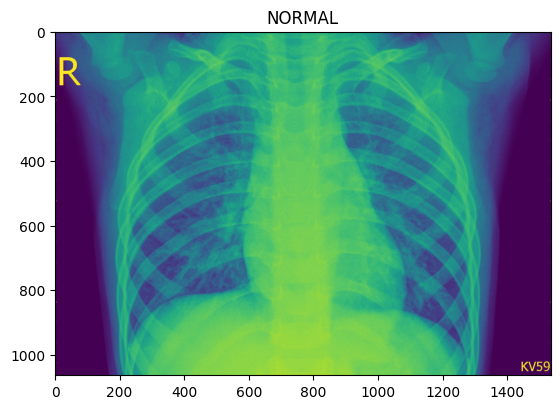

In [5]:
img = view_random_image('chest_xray/test/', 'NORMAL')
img

In [6]:
tf.constant(img)

<tf.Tensor: shape=(1064, 1536), dtype=uint8, numpy=
array([[36, 37, 37, ..., 16, 16, 16],
       [35, 36, 38, ..., 16, 16, 16],
       [34, 36, 38, ..., 16, 16, 16],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], shape=(1064, 1536), dtype=uint8)>

In [7]:
# View the image shape
img.shape # Returns width, height, colour channels

(1064, 1536)

In [8]:
# Get all the pixel values between 0 and 1
img/255.

array([[0.14117647, 0.14509804, 0.14509804, ..., 0.0627451 , 0.0627451 ,
        0.0627451 ],
       [0.1372549 , 0.14117647, 0.14901961, ..., 0.0627451 , 0.0627451 ,
        0.0627451 ],
       [0.13333333, 0.14117647, 0.14901961, ..., 0.0627451 , 0.0627451 ,
        0.0627451 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(1064, 1536))

In [18]:
### An end-to-end example
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(   rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale = 1./255)

# Setup path to our data directory
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory = train_dir, batch_size=32, target_size=(224, 224),
                                               class_mode = "binary", seed=42)

valid_data = valid_datagen.flow_from_directory(directory = test_dir, batch_size=32, target_size=(224, 224), class_mode="binary", seed=42)

# Build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
      # tf.keras.layers.Activations(tf.nn.relu)
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile our CNN
model_1.compile(loss="binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics = ["accuracy"]
                )
# Fit the model
history_1 = model_1.fit(train_data, epochs=5, steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps=len(valid_data))


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 266ms/step - accuracy: 0.7435 - loss: 0.5342 - val_accuracy: 0.7115 - val_loss: 0.5224
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 262ms/step - accuracy: 0.8566 - loss: 0.3415 - val_accuracy: 0.8462 - val_loss: 0.3515
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 248ms/step - accuracy: 0.8965 - loss: 0.2553 - val_accuracy: 0.8574 - val_loss: 0.3200
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 238ms/step - accuracy: 0.9110 - loss: 0.2170 - val_accuracy: 0.8814 - val_loss: 0.2924
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 232ms/step - accuracy: 0.9193 - loss: 0.2043 - val_accuracy: 0.8766 - val_loss: 0.2885


In [23]:
model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        28,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,305 (364.48 KB)

 Trainable params: 31,101 (121.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,204 (242.99 KB)

In [24]:
test_loss, test_accuracy = model_1.evaluate(
    valid_data,
    steps=len(valid_data)
)

test_loss, test_accuracy

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.8766 - loss: 0.2885


(0.2885274291038513, 0.8766025900840759)

In [25]:
pred_probs = model_1.predict(valid_data, steps=len(valid_data))
pred_probs

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step


array([[0.95764244],
       [0.21879788],
       [0.29422435],
       [0.9882863 ],
       [0.994847  ],
       [0.730242  ],
       [0.26762575],
       [0.7124791 ],
       [0.9930993 ],
       [0.99765253],
       [0.01695159],
       [0.02877813],
       [0.57744575],
       [0.97104204],
       [0.98090816],
       [0.9971077 ],
       [0.8777985 ],
       [0.14776856],
       [0.9928754 ],
       [0.8393365 ],
       [0.12183193],
       [0.5769882 ],
       [0.7628137 ],
       [0.95320755],
       [0.9642947 ],
       [0.5801664 ],
       [0.9727198 ],
       [0.9597433 ],
       [0.39730617],
       [0.9563854 ],
       [0.2298414 ],
       [0.01645547],
       [0.990148  ],
       [0.9877723 ],
       [0.98838043],
       [0.9618435 ],
       [0.19047426],
       [0.01513481],
       [0.03407059],
       [0.04190929],
       [0.11553548],
       [0.25500455],
       [0.8526382 ],
       [0.94435185],
       [0.9849509 ],
       [0.07457013],
       [0.88932884],
       [0.256

In [26]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [27]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


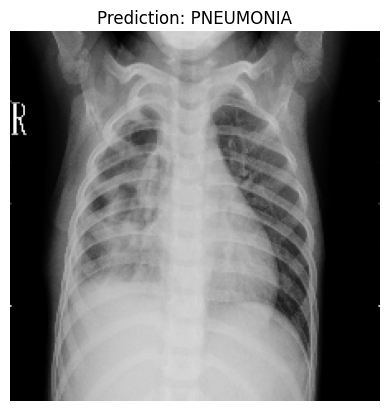

In [28]:
pred_and_plot(model_1, "chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


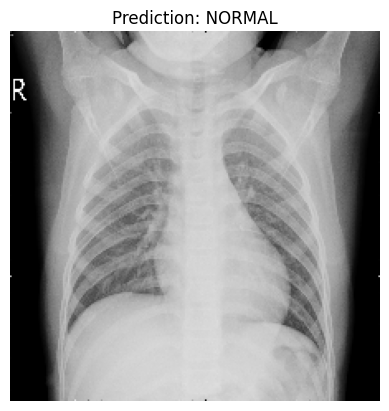

In [29]:
pred_and_plot(model_1, "chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


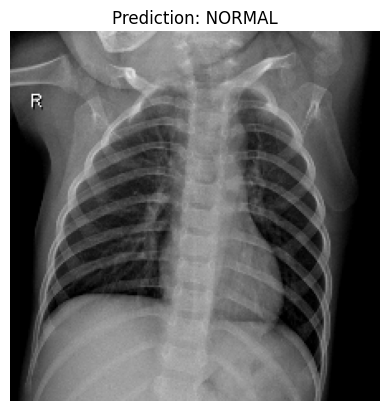

In [30]:
pred_and_plot(model_1, "chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


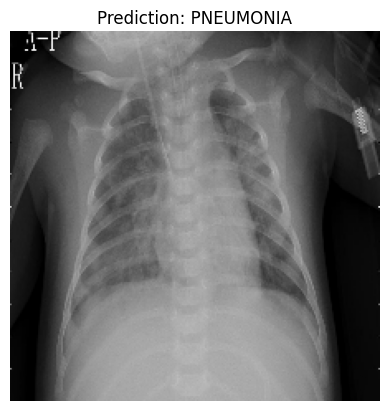

In [31]:
pred_and_plot(model_1, "chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


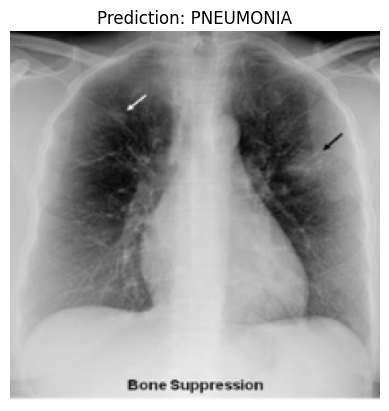

In [38]:
pred_and_plot(model_1, "download1_true.jpeg", class_names)